<a href="https://colab.research.google.com/github/BigDave07/How-AI-Sees-Sound/blob/main/How_AI_sees_sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving A3 recording.m4a to A3 recording.m4a


In [2]:
import IPython.display as ipd
filename = list(uploaded.keys())[0]
ipd.Audio(filename)

/tmp/ipython-input-1537306500.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(filename)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


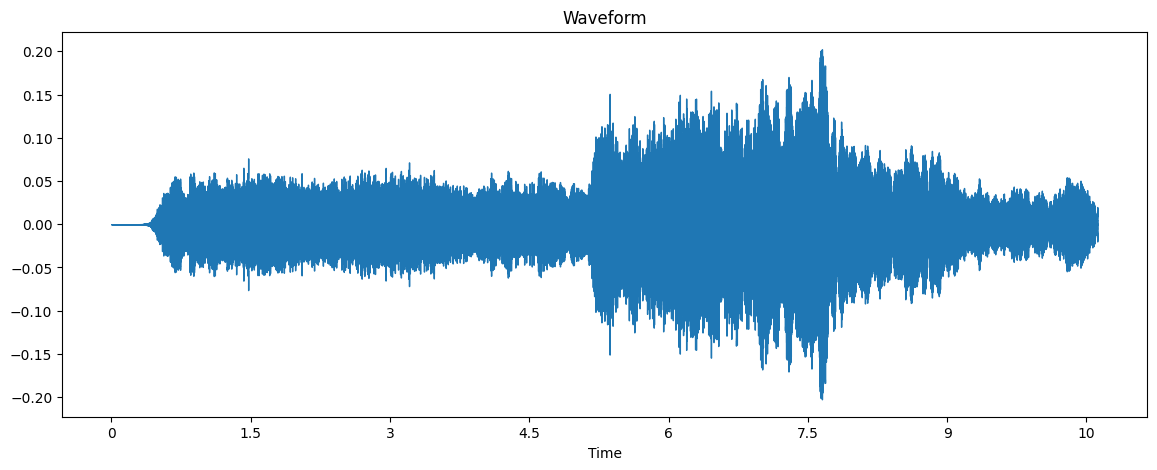

10.62 seconds
Sample Rate22050


In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
audio, sr = librosa.load(filename)
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform")
plt.show()
print(f"{len(audio)/sr:.2f} seconds\nSample Rate {sr}")

DISPLAY SPECTROGRAM

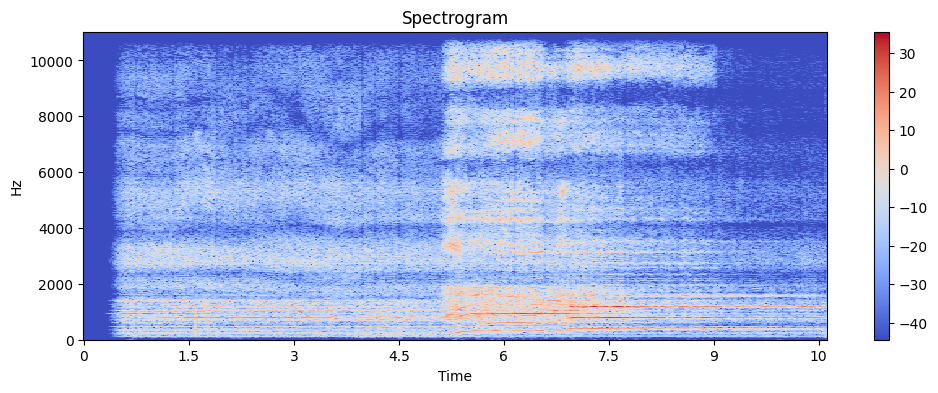

In [4]:
X = librosa.stft(audio)
Xbd = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(12,4))
librosa.display.specshow(Xbd, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram")
plt.show()

EXTRACT BASIC FEATURES

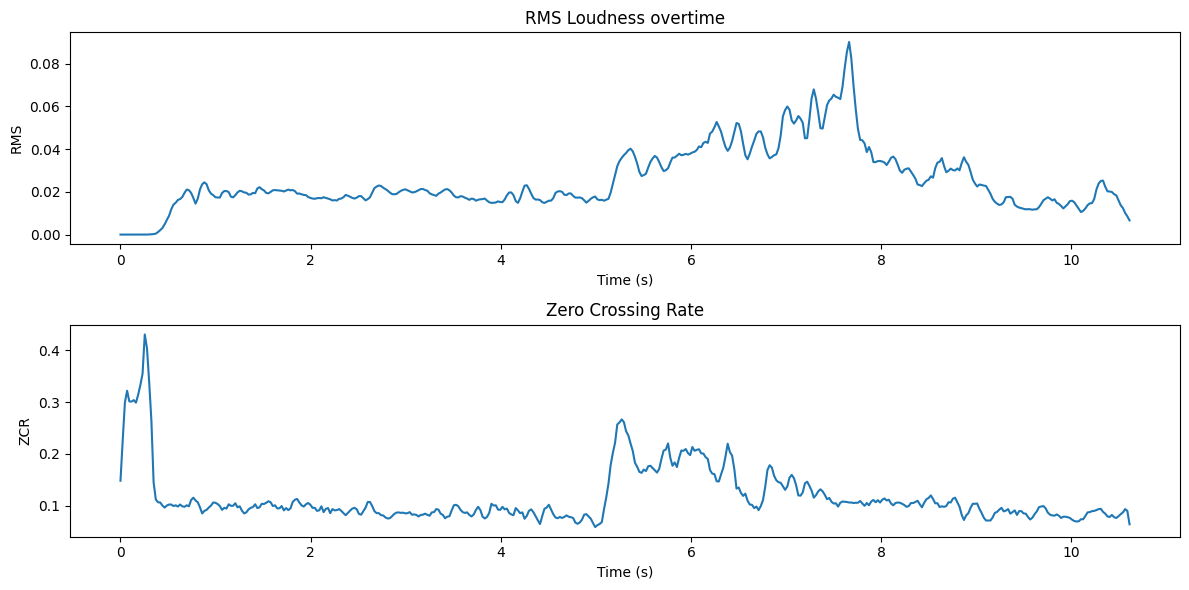

In [6]:
import numpy as np

frame_length = 2048
hop_length = 512

rms = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=frame_length, hop_length=hop_length)[0]

#Time Axis for Ploting
time = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)


plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(time, rms)
plt.title("RMS Loudness overtime")
plt.xlabel("Time (s)"); plt.ylabel("RMS")

plt.subplot(2,1,2)
plt.plot(time, zcr)
plt.title("Zero Crossing Rate")
plt.xlabel("Time (s)"); plt.ylabel("ZCR")

plt.tight_layout()
plt.show()


Extract pitch contour

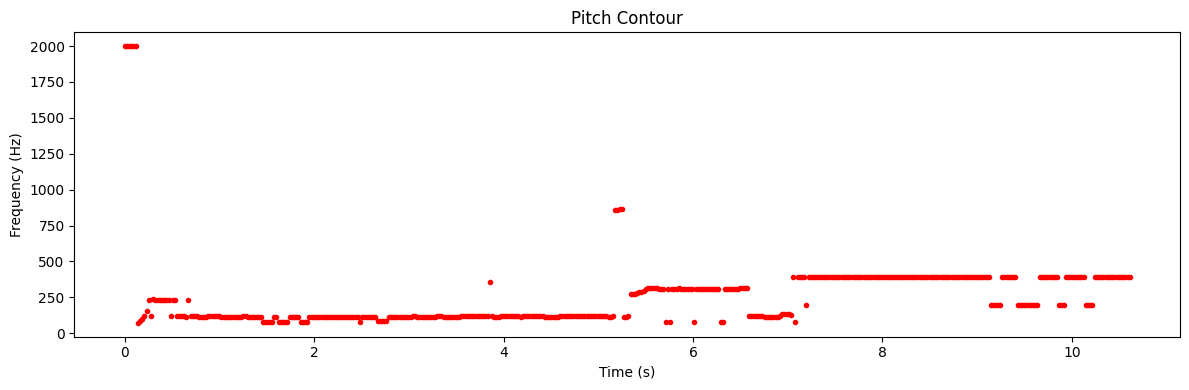

In [8]:
f0 = librosa.yin(
    audio,
    fmin= librosa.note_to_hz('C2'),  #Lower Bound
    fmax= librosa.note_to_hz('C7'), #Higher Bound
    sr= sr,
    frame_length = frame_length,
    hop_length = hop_length
)

pitch_times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

plt.figure(figsize=(12,4))
plt.plot(pitch_times, f0, marker='.', linestyle='none', color='r')
plt.title("Pitch Contour")
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

Convert pitch (Hz) → musical notes

Seeing Hz is cool, but singers think in notes: A3, C4, F#4, etc.

In [9]:
f0_clean = f0.copy()
note_names = []

for freq in f0_clean:
  if np.isnan(freq):
    note_names.append(None)
  else:
    note_names.append(librosa.hz_to_note(freq))

#Show small segment
for t, freq, note in list(zip(pitch_times, f0_clean, note_names))[:20]:
    print(f"time={t:5.2f}s  freq={freq:7.2f} Hz  note={note}")

time= 0.00s  freq=1998.84 Hz  note=B6
time= 0.02s  freq=1998.84 Hz  note=B6
time= 0.05s  freq=1998.84 Hz  note=B6
time= 0.07s  freq=1998.84 Hz  note=B6
time= 0.09s  freq=1998.84 Hz  note=B6
time= 0.12s  freq=1998.84 Hz  note=B6
time= 0.14s  freq=  72.18 Hz  note=D2
time= 0.16s  freq=  82.21 Hz  note=E2
time= 0.19s  freq=  98.71 Hz  note=G2
time= 0.21s  freq= 119.67 Hz  note=A♯2
time= 0.23s  freq= 156.11 Hz  note=D♯3
time= 0.26s  freq= 233.86 Hz  note=A♯3
time= 0.28s  freq= 118.34 Hz  note=A♯2
time= 0.30s  freq= 235.65 Hz  note=A♯3
time= 0.33s  freq= 234.66 Hz  note=A♯3
time= 0.35s  freq= 233.49 Hz  note=A♯3
time= 0.37s  freq= 234.36 Hz  note=A♯3
time= 0.39s  freq= 233.32 Hz  note=A♯3
time= 0.42s  freq= 233.53 Hz  note=A♯3
time= 0.44s  freq= 234.02 Hz  note=A♯3


Compare Target Note

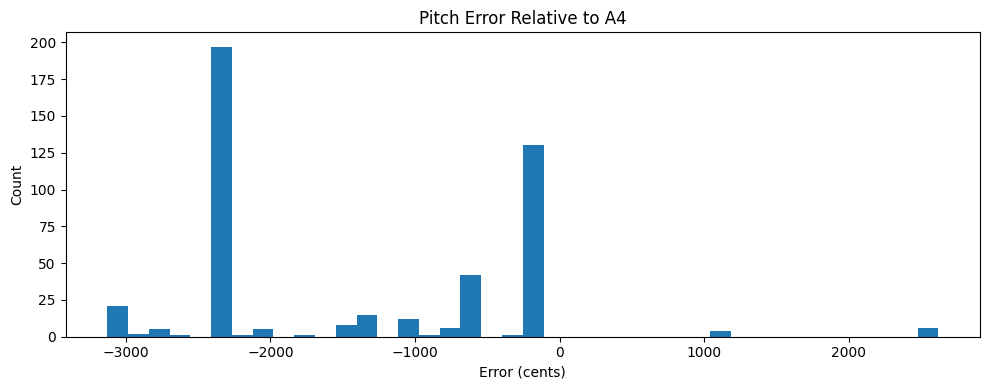

Mean pitch error: -1388.6 cents
Std pitch error : 1121.1 cents


In [10]:
target_note = 'A4'
target_freq = librosa.note_to_hz(target_note)

# Only consider frames where we have a pitch
mask = ~np.isnan(f0_clean)
pitch_err_cents = 1200 * np.log2(f0_clean[mask] / target_freq)

plt.figure(figsize=(10,4))
plt.hist(pitch_err_cents, bins=40)
plt.title(f"Pitch Error Relative to {target_note}")
plt.xlabel("Error (cents)"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(f"Mean pitch error: {np.mean(pitch_err_cents):.1f} cents")
print(f"Std pitch error : {np.std(pitch_err_cents):.1f} cents")


Interpretation:

0 cents = perfectly in tune with A4

±20–30 cents = slightly off but often acceptable

±50 cents = clearly flat or sharp

This is EXACTLY the type of calculation a singing coach app would do to give feedbac